## Download and Annotate the dataset

#### LogoDet-3K

##### Download

In [ ]:
import os
os.makedirs("Datasets", exist_ok=True)
%cd Datasets

/content/LOGOS/Datasets


1. Download using wget no authorization needed
2. (Faster) Download using kaggle authorization needed, put you kaggle.json file in Datasets folder

In [ ]:
## Download without authorization or any type of permission
!wget 123.57.42.89/Dataset_ict/LogoDet-3K.zip

--2022-07-10 19:29:33--  http://123.57.42.89/Dataset_ict/LogoDet-3K.zip
Connecting to 123.57.42.89:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3079016292 (2.9G) [application/zip]
Saving to: ‘LogoDet-3K.zip’

LogoDet-3K.zip        2%[                    ]  68.59M   662KB/s    eta 73m 35s^C


In [ ]:
## download LogoDet-3K from kaggle
! mkdir ~/.kaggle
## Put kaggle.json in the Dataset folder
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lyly99/logodet3k
! unzip \*.zip && rm *.zip

## Annotate

You can choose to annotate the entire LogoDet3K datasets or just download the dataset and use our annotations which is availaible in annotation_logodet3k.pckl file

If you will be annotating the dataset please execute the cells below

In [ ]:
## Get a list of all files in logodet3k
listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk("/content/Datasets/LogoDet-3K"):
    listOfFiles += [os.path.join(dirpath, file[:-4]) for file in filenames if file[-3:]=="jpg"]

print(len(listOfFiles))

158654


Download CRAFT for Annotations

In [ ]:
%cd /content/
!git clone https://github.com/LaotechLabs/LOGOS.git
%cd /content/LOGOS

/content
fatal: destination path 'LOGOS' already exists and is not an empty directory.
/content/LOGOS


In [ ]:
os.makedirs("models", exist_ok=True)
%cd /content/LOGOS/models
## Clone the repository
!git clone https://github.com/clovaai/CRAFT-pytorch.git
%cd /content/LOGOS/models/CRAFT-pytorch/
## download craft weights 
!gdown 1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ

/content/LOGOS/models
fatal: destination path 'CRAFT-pytorch' already exists and is not an empty directory.
/content/LOGOS/models/CRAFT-pytorch
Downloading...
From: https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
To: /content/LOGOS/models/CRAFT-pytorch/craft_mlt_25k.pth
100% 83.2M/83.2M [00:00<00:00, 222MB/s]


In [ ]:
cp /content/LOGOS/utils/textdetect.py /content/LOGOS/models/CRAFT-pytorch

In [ ]:
pwd

'/content/LOGOS'

In [ ]:
from textdetect import textdetection

textdetector = textdetection()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from checkpoint (craft_mlt_25k.pth)


## Annotate

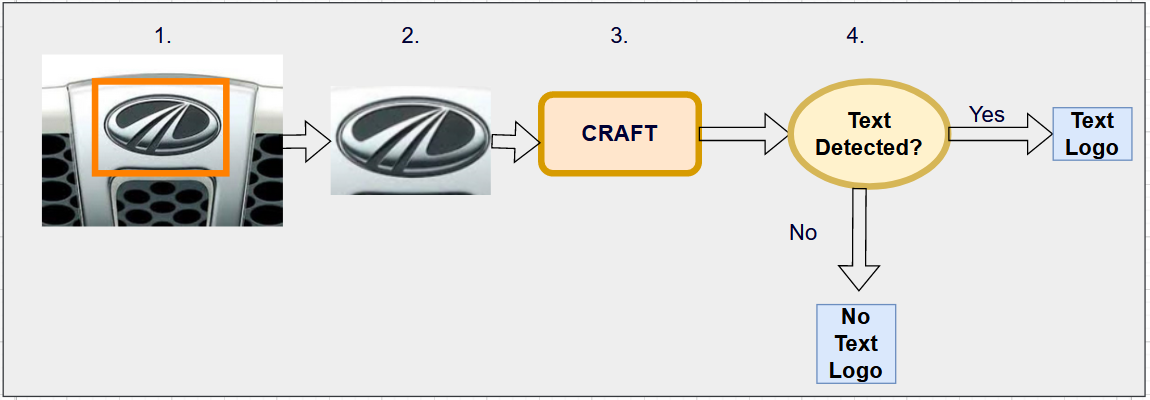

We used the following steps to annotate the data:

    1. Extracted the bounding box coordinates from the already available annotated logo datasets.
    2. Cropped the image for that bounding box to get that particular region
    3. Gave cropped logo image as input to the text detection model. We used CRAFT: Character-Region Awareness For Text detection as the text detector.
    4. If text is detected, we label that particular bounding box as “Text”. Else we label the bounding box as “NoText”.

Annotation LogoDet-3K 

In [ ]:
from bs4 import BeautifulSoup
from skimage import io
import cv2

def loadImage(img_file):
    img = io.imread(img_file)           # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)

    return img

In [ ]:
## text and notext variables counts the number of bounding boxes with text and no text respectively
text = 0
notext = 0
numimgs = 0 ## count the number of images done
# load data
for id in listOfFiles:
  image_path = id+".jpg"
  ## Load the image
  image = loadImage(image_path)
  xml_path = id+".xml"
  numimgs+=1
  ## read xml file data
  with open(xml_path, 'r+') as f:
    data = f.read()
  
    # get the bounding box from the xml file
    Bs_data = BeautifulSoup(data, "xml")
    b_unique = Bs_data.find_all('object')
    for box in b_unique:
      xmin = int(box.find('xmin').text)
      xmax = int(box.find('xmax').text)
      ymin = int(box.find('ymin').text)
      ymax = int(box.find('ymax').text)
      # Crop the image corresponding to the counding box
      img = image[ymin:ymax, xmin:xmax]
      try:
        # See if text is detected in the cropped part
        bboxes = textdetector.predict(img)
      except:
        continue
      if len(bboxes)>0:
        text+=1
        box.find('name').string = "Text"
      else:
        notext+=1
        box.find('name').string = "NoText"
    f.close()

  with open(xml_path, 'w') as f:
    f.write(Bs_data.prettify())
    f.close()
  
  if((text+notext)%5000==0):
    print(f"Number of images processed till now: {numimgs}")
    print(f"Number of bounding boxes with label Text: {text}")
    print(f"Number of bounding boxes with label NoText: {notext}")
    break

Number of images processed till now: 7705
Number of bounding boxes with label Text: 8607
Number of bounding boxes with label NoText: 1393


##### Get all annotations and export as pickle file

In [ ]:
img2bbox = {} ## our annotations dictionary
num = 0 ## To keep track of number of images processed
# load data
for id in listOfFiles:
    xml_path = id+".xml"
    img_path = id+".jpg"
    img = Image.open(img_path)
    img_size = img.size
    #print(img_size)
    num+=1
    bboxes = []
    labels = []
    with open(xml_path, 'r') as f:
        data = f.read()
        Bs_data = BeautifulSoup(data, "xml")
        b_unique = Bs_data.find_all('object')
        for box in b_unique:
            label = box.find('name').text[4:-3]
            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            
            bbox = [xmin, ymin, xmax, ymax]
            
            bboxes.append(bbox)
            labels.append(label)

        img2bbox[id+".jpg"] = (bboxes, labels, img_size)
        f.close()
    
    if((num)%10000==0):
        print(f"Number of images processed: {num}")

Number of images processed: 10000
Number of images processed: 20000


KeyboardInterrupt: ignored

In [ ]:
## Dump into file to use
import pickle as pkl
filename = "annotations_logodet3k.pkl"
a_file = open(filename, "wb")

pkl.dump(img2bbox, a_file)

a_file.close()

In [ ]:
## download the file
from google.colab import files
filename = "annotations_logodet3k.pkl"
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visuallly29K

## Download the dataset

In [ ]:
import pickle as pkl
from PIL import Image
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pprint
import time
import urllib

In [ ]:
## clone the visuallydata repository from github
!git clone https://github.com/diviz-mit/visuallydata.git 
os.makedirs('/content/Datasets/visuallydata-20k', exist_ok=True)
!cp /content/visuallydata/infographics60K_metadata.pckl /content/Datasets/visuallydata-20k/
!cp /content/visuallydata/detectionsList_classified.pckl /content/Datasets/visuallydata-20k/

Cloning into 'visuallydata'...
remote: Enumerating objects: 331, done.
remote: Total 331 (delta 0), reused 0 (delta 0), pack-reused 331
Receiving objects: 100% (331/331), 76.30 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Checking out files: 100% (175/175), done.


In [ ]:
## put this code in a python file with infographicInfo as name and put it in content directory
class infographicInfo:
    def __init__(self,currow):
        self.views = int(currow['views']);
        self.likes = int(currow['likes']);
        self.shares = int(currow['shares']);
        self.comments = int(currow['comments']);
        self.staffPick = currow['staffPick'];
        self.imgurl = currow['url_img_ful_res'];
        self.mainurl = currow['url'];
        self.title = currow['igTitle'];
        self.category = currow['category'];
        self.description = currow['description'];
        self.title = currow['title'];
        self.tags = currow['tags'];

In [ ]:
infographicList = pkl.load(open("/content/Datasets/visuallydata-20k/infographics60K_metadata.pckl", "rb"))

In [ ]:
print('We include meta-data obtained from Visual.ly for %d infographics. We call this the 63K dataset.\n'\
       'No additional filtering or annotations are provided beyond what is already found on Visual.ly.\n'\
       'This is the original, uncurated data.\n'\
      'Note: we do not provide the downloaded images themselves, only the URLs for download.'
      %(len(infographicList)))

We include meta-data obtained from Visual.ly for 63738 infographics. We call this the 63K dataset.
No additional filtering or annotations are provided beyond what is already found on Visual.ly.
This is the original, uncurated data.
Note: we do not provide the downloaded images themselves, only the URLs for download.


In [ ]:
# Here we can see all the meta-data that is available per infographic.
print(infographicList[0].__dict__)

{'category': 'Business', 'comments': 7, 'views': 8760, 'description': "Visually's latest report dives into the relationship between marketers and creatives.", 'title': 'Marketers vs Creatives: Communication Breakdown', 'staffPick': 'FALSE', 'shares': 75, 'imname': 'marketers-vs-creatives-communication-breakdown-thumbnail_5639568df0acc.png', 'tags': ['marketing', 'content', 'markting in business', 'designers'], 'likes': 150, 'transcript': [], 'imgurl': 'http://thumbnails.visually.netdna-cdn.com/marketers-vs-creatives-communication-breakdown-thumbnail_5639568df0acc_h1000.png', 'mainurl': 'http://visual.ly/marketers-vs-creatives-communication-breakdown'}


In [ ]:
import socket

outdir = '/content/Datasets/visuallydata-20k' # where to save the downloaded image files

if not os.path.exists(outdir):
    os.makedirs(outdir)

## download 20000 images first though to reduce class imbalance we only need 5000 images from the dataset
for i in range(20000):
    # use this url directly to obtain images (with limits on image width, indicated by '_w1000' in the filename)
    url = infographicList[i].imgurl 
    
    # use this adjusted url to obtain full-size images
    usp = url.rfind('_') # underscore position
    pp = url.rfind('.') # period position
    fullsizeimurl = url[:usp] + url[pp:] # full size image url
    
    # the above is identical to just using the following, except for 3 images that have exceptionally long filenames
    # (image IDs: 8865, 44810, 45886)
    imname = infographicList[i].imname 
    fullurl = 'http://thumbnails.visually.netdna-cdn.com/%s'%(imname)
    
    #urllib.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 2
    #socket.setdefaulttimeout(15)
    try:
        urllib.request.urlretrieve(fullsizeimurl, os.path.join(outdir,imname)) # python 3
    except:
        print(f"{fullsizeimurl} couldn't be downloaded")
    
    time.sleep(1) # to avoid launching too many download requests at once
    if i%10000==0:
        print(f'{i} images downloaded')

0 images downloaded
http://thumbnails.visually.netdna-cdn.com/a-whos-who-of-the-minions_51d54556b6828.jpg couldn't be downloaded


KeyboardInterrupt: ignored

In [ ]:
detectionsList = pkl.load(open("/content/Datasets/visuallydata-20k/detectionsList_classified.pckl", "rb"))
print('Icon detections and classifications are available for %d infographics.'%(len(detectionsList)))

IMDIR = '/content/Datasets/visuallydata-20k/'
listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(IMDIR):
    listOfFiles += [file for file in filenames if file.split('.')[1]!="pckl"]

print(listOfFiles)

Icon detections and classifications are available for 63560 infographics.
['100-years-of-change_51af4f3f85832.jpg', 'CutsofBeef_515c59b0b3865.jpg', 'ShouldITextHimFlowchart_50a68cf36d200.jpg', 'battling-cybercrime-thumbnail_53f30b7e1c504.png', 'marketers-vs-creatives-communication-breakdown-thumbnail_5639568df0acc.png', '9-unbelievably-simple-steps-to-perfect-makeup_53300a153e3d6.jpg', 'finding-the-perfect-career-for-your-marriage_570fe2896faf9.jpg', '11-untranslatable-words-from-other-cultures_52152bbe65e85.png', 'what-are-the-odds_50290d9b95578.png', 'a-tale-of-two-cows_5125901371eac.jpg', 'an-anthology-of-mythical-creatures-thumbnail_547cfbd2166b7.png', 'why-you-should-choose-dental-implants_57fc64b0b45de.jpg', 'what-does-your-handwriting-say-about-you_51cb3586d1131.jpg', 'TheWorldas100People_519247ce0980d.png', 'how-to-build-a-lawn-sprinkler-system-using-pipe-glue-or-cement_53cf3ada92f9c.jpg', 'we-stack-up-vs-the-competition_547c90c236e20.png', 'dont-ask-dr-google--hes-not-an-actua

In [ ]:
text = 0
notext = 0
annotations = {}
i = 0
for id in listOfFiles:
  image_path = IMDIR+ id
  try:
    i+=1
    boxes = []
    labels = []
    # Load the image
    image = loadImage(image_path)
    im = cv2.imread(os.path.join(IMDIR,id))
    bboxlist = detectionsList[id]
    h,w, _ = image.shape
    for item in bboxlist:
      # Get the bounding box
      bboxnums = item.split()
      xmin = int(w*float(bboxnums[0])/1000.0)
      xmax = int(w*float(bboxnums[2])/1000.0)
      ymin = int(h*float(bboxnums[1])/1000.0)
      ymax = int(h*float(bboxnums[3])/1000.0)
      # Crop the image according to the bounding box
      img = image[ymin:ymax, xmin:xmax]
      try:
        # See if text is detected from the cropped image
        bboxes = textdetector.predict(img)
        if len(bboxes)>0:
          text+=1
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append('NoText')
        else:
          notext+=1
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append('NoText')
      except:
        print("Error while using text detector in:", id)
    if boxes:
      annotations[image_path] = (boxes, labels, (w, h))
  except:
    print("Error while opening the image:", image_path)

  if((text+notext)%5000==0):
    print(f"Number of images processed till now: {i}")
    print(f"Number of bounding boxes with label Text: {text}")
    print(f"Number of bounding boxes with label NoText: {notext}")

2: /content/Datasets/visuallydata-20k/finding-the-perfect-career-for-your-marriage_570fe2896faf9.jpg


In [ ]:
## Export annotations file as pkl
a_file = open("annotations_visuallydata_20k.pkl", "wb")

pkl.dump(annotations, a_file)

a_file.close()

In [ ]:
## download the file
from google.colab import files
filename = "annotations_visuallydata_20k.pkl"
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>